In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
import GunshotDataset
from PopMusicInformationRetrieval import gunshot_utils as utils
import importlib
import torch as th
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import librosa
import ast
import re
import soundfile as sf
from pydub.playback import play
import os
import numpy as np
import torchaudio
import GunshotModel
import GunshotDetection
from torch.optim import Adam
import torch.nn as nn

importlib.reload(utils)
importlib.reload(GunshotDetection)
importlib.reload(GunshotDataset)
importlib.reload(GunshotModel)

<module 'GunshotModel' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/GunshotModel.py'>

In [137]:
gunshot_df = pd.read_pickle('pkl_data/gunshot_data_glock_only.pkl')
gunshot_df = gunshot_df[['filename', 'gunshot_location_in_seconds', 'num_gunshots']]
gunshot_df

,filename,gunshot_location_in_seconds,num_gunshots
0,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.72269841],1
41,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
42,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
43,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
44,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"[1.75, 3.63755102, 5.55709751]",3
...,...,...,...
1552,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
1572,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[7.49117914],1
1573,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
1607,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"[0.04662132, 0.31596372, 1.33662132, 1.6201133...",6


In [119]:
gunshots = pd.read_csv('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Audio/Gunshots/csv/edge-collected-gunshot-audio/filtered_gunshot_metadata.csv')
gunshots = gunshots[['filename', 'num_gunshots', 'gunshot_location_in_seconds']]

# This function is needed because for some reason the gunshots start list is treated as string for some reason.
def preprocess_gunshot_times(gunshot_times):
    # Remove multiple spaceS
    gunshot_times = re.sub(r'\s+', ' ', gunshot_times).strip()

    # Insert commas between numbers if missing
    gunshot_times = re.sub(r'(?<=\d)\s(?=\d)', ', ', gunshot_times)

    # Ensure there are no trailing commas
    gunshot_times = gunshot_times.replace(', ]', ']')

    # Safely evaluate the string as a list
    try:
        return ast.literal_eval(gunshot_times)
    except (ValueError, SyntaxError):
        # Return an empty list if the string is not a valid list
        return []

# # Apply the function to the 'gunshot_location_in_seconds' column
gunshots['gunshot_location_in_seconds'] = gunshots['gunshot_location_in_seconds'].apply(preprocess_gunshot_times)

In [120]:
gunshots

,filename,num_gunshots,gunshot_location_in_seconds
0,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,1,[1.72269841]
1,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,1,[1.67290249]
2,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,3,"[1.61977324, 3.50795918, 5.42746032]"
3,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,3,"[1.75, 1.98768707, 2.26022676]"
4,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,3,"[1.75, 2.61845805, 3.06664399]"
...,...,...,...
941,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,1,[1.7406576]
942,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,1,[1.66732426]
943,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,5,"[1.53469388, 1.74122449, 2.14659864, 2.3253288..."
944,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,5,"[1.75, 1.94283447, 2.34698413, 2.52979592, 2.7..."


In [121]:
# gunshots['filename'] = gunshots['filename'].apply(change_filename)
gunshots['label'] = 1

In [122]:
music_df = pd.read_pickle('/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/music_with_onsets_wav.pkl')

In [123]:
music_df

,filename,num_gunshots,gunshot_location_in_seconds,label,onsets,num_onsets,new_filename
0,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.14933333333333335, 0.384, 1.130666666666666...",1650,./Data/gunshot/8 Iz Enuff.wav
1,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.128, 2.2826666666666666, 2.421333333333333,...",1811,./Data/gunshot/Da Graveyard.wav
2,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.13866666666666666, 0.7893333333333333, 1.10...",1261,./Data/gunshot/I Don't Understand It.wav
3,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.14933333333333335, 4.074666666666666, 4.917...",1006,"./Data/gunshot/No Endz, No Skinz.wav"
4,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.13866666666666666, 0.23466666666666666, 0.5...",867,./Data/gunshot/MVP.wav
...,...,...,...,...,...,...,...
1359,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.07466666666666667, 0.16, 1.7813333333333334...",1327,./Data/gunshot/Dr. Dre - The Day the Niggaz To...
1360,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.256, 0.416, 0.448, 0.6186666666666667, 0.94...",1322,./Data/gunshot/Dr. Dre - Bitches Ain't Shit (f...
1361,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.30933333333333335, 0.384, 1.792, 1.89866666...",1779,./Data/gunshot/Dr. Dre - Stranded On Death Row...
1362,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,0,0,0,"[0.07466666666666667, 0.224, 0.874666666666666...",999,./Data/gunshot/Dr. Dre - Nuthin' but a ＂G＂ Tha...


In [124]:
music_df = music_df.drop(columns=['filename'])
music_df = music_df.rename(columns={'new_filename': 'filename'})

In [125]:
music_df["filename"] = music_df["filename"].str.replace(
    "./Data/gunshot",
    "/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/Data/gunshot",
    regex=False
)

In [126]:
# Generate metadata
# audio_metadata = utils.generate_audio_metadata_from_df(music_df, 'filename')
# 
import pickle
# 
# with open("./audio_metadata.pkl", "wb") as file:
#     pickle.dump(audio_metadata, file)

with open("./audio_metadata.pkl", "rb") as file:
    audio_metadata = pickle.load(file)

In [127]:
music_train_df, music_valid_df = train_test_split(music_df, test_size=0.2, random_state=42)

# We don't take the gunshot_valid here because we have our own validation set.
gunshot_train_df, gunshot_valid_df = train_test_split(gunshot_df, test_size=0.2, random_state=42)

In [143]:
train_dataset = GunshotDataset.GunshotDataset(music_train_df, gunshot_train_df, audio_metadata, gunshot_prob=0.5, num_samples=800, real_music_gunshot=False) # This means that with 50% probability it will generate gunshot samples. In total 800 samples.
valid_dataset = GunshotDataset.GunshotDataset(music_valid_df, gunshot_valid_df, audio_metadata, gunshot_prob=0.5, num_samples=320, real_music_gunshot=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

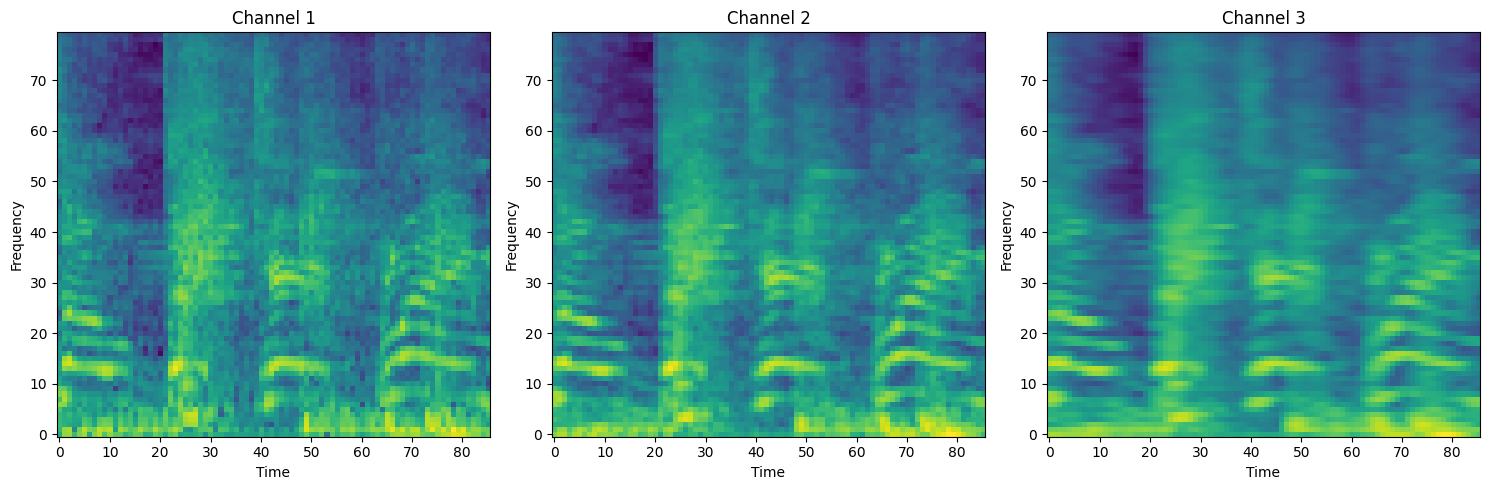

In [129]:
waveform, spectrogram = train_dataset.get_random_music_onset()
# plot_spectrogram_rgb(spectrogram)
utils.play_audio(waveform)
utils.plot_spectrogram_channels(spectrogram)

In [151]:
waveform, gunshot_waveform, spectrogram = train_dataset.get_random_music_with_gunshot()
# plot_spectrogram_rgb(spectrogram)
utils.play_audio(gunshot_waveform)
# utils.plot_spectrogram_channels(spectrogram)

In [152]:
utils.play_audio(waveform)

In [193]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
use_cuda = th.cuda.is_available()
torchaudio.set_audio_backend("soundfile")

mean, std = utils.compute_mean_std(train_loader)
mean = mean.to(device)
std = std.to(device)

Computing mean and std: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


In [198]:
importlib.reload(utils)
importlib.reload(GunshotDetection)
importlib.reload(GunshotDataset)
importlib.reload(GunshotModel)

<module 'GunshotModel' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/GunshotModel.py'>

Epoch 1/10


Epoch [1] Training: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s, loss=0.697]


Epoch [1], Training Loss: 0.7227
Epoch [1], Validation Loss: 0.6640
Epoch [1], AUC-ROC: 0.6697, PR-AUC: 0.7643
New best f1: 0.5486, model saved.
Epoch 2/10


Epoch [2] Training: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s, loss=0.615]


Epoch [2], Training Loss: 0.6556
Epoch [2], Validation Loss: 0.6589
Epoch [2], AUC-ROC: 0.6399, PR-AUC: 0.7343
New best f1: 0.6207, model saved.
Epoch 3/10


Epoch [3] Training: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s, loss=0.719]


Epoch [3], Training Loss: 0.6573
Epoch [3], Validation Loss: 0.6261
Epoch [3], AUC-ROC: 0.6479, PR-AUC: 0.7216
Epoch 4/10


Epoch [4] Training: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s, loss=0.566]


Epoch [4], Training Loss: 0.6269
Epoch [4], Validation Loss: 0.6196
Epoch [4], AUC-ROC: 0.7300, PR-AUC: 0.7743
Epoch 5/10


Epoch [5] Training: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, loss=0.685]


Epoch [5], Training Loss: 0.6544
Epoch [5], Validation Loss: 0.5849
Epoch [5], AUC-ROC: 0.6897, PR-AUC: 0.7597
No improvement in f1 for 3 epochs. Stopping training.


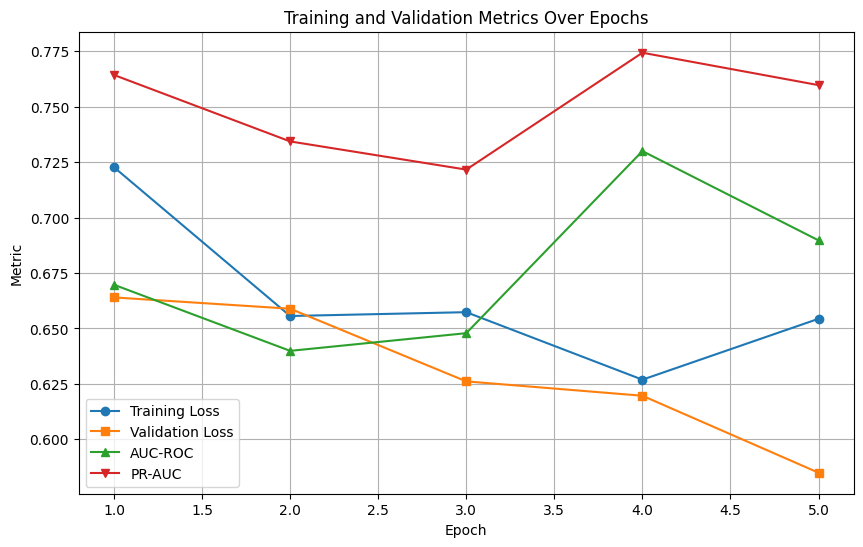

In [200]:
# Initialize model
num_frames = utils.NUM_FRAMES
model = GunshotModel.GunshotDetectionCNN(num_frames)

# Define optimizer and loss
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Calculate mean and std for normalization
means = []
stds = []
for spectrogram, _, _ in train_loader:
    means.append(spectrogram.mean())
    stds.append(spectrogram.std())
mean = th.tensor(means).mean()
std = th.tensor(stds).mean()

# Initialize training manager
training_manager = GunshotDetection.GunshotDetectionTrainer(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=10,
    mean=mean,
    std=std,
    eval_metric='f1',
    patience=3
)

# Train the model
best_threshold, best_score, last_failed_samples = training_manager.train()